In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from haversine import haversine
import itertools

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(16,9)
plt.rcParams['axes.grid'] = False

def bic_scorer(estimator, X, y):
    return -1*(len(X) * np.log(mean_squared_error(y, estimator.predict(X))) + 2 * np.sum([i.shape[0] * i.shape[1] for i in mlp.coefs_]))

def import_runs(name: str, r: 'iterable') -> pd.DataFrame:
    '''
    Function for importing and stitching together Garmin .gpx files saved as Excel notebooks.
    Files follow the naming convention of "[Name] [Number]". For example: Run Sample 1, Run Sample 2, etc. In this case, [Name] = "Run Sample".
    
    Arguments:
        - name: The string portion of the file name that the files being stiched together have in common.
        - r: A list containing the variable portion of the file names.
        
    Return: A DataFrame containing the combined Excel files' data, along with some diff() calculations.
    
    Columns:
        - hr: Observed heart rate (bpm)
        - cadence: Observed strides per minute (per leg, so typical cadence / 2)
        - depth: How long into the run (in minutes) that the observation was made
        - speed: Observed speed (km/min)
        - speed_gain: Change in speed (km/min) from previous observation
        - elev_gain: Change in altitude (meters) from previous observation
        - prev_hr: Heart rate (bpm) from previous observation
    '''
    
    # List of fields from sheets to drop once we're done with them
    drop_list = ['lat', 'lon', 'prev_lat', 'prev_lon', 'ns1:ele', 'ns1:time', 'ns1:time2']
    
    # Empty DataFrame to append individual run sheets to
    data = pd.DataFrame()

    for i in r:
        # Iterate through all sheets, perform LAG/LEAD operations, append to main DataFrame

        df = (pd.read_excel(f'{name} {i}.xlsx', converters = {'ns1:time': pd.to_datetime, 'ns1:time2': pd.to_datetime})
              [['ns1:time', 'lat', 'lon', 'ns1:ele', 'ns1:time2', 'ns2:hr', 'ns2:cad']]
             )
        df.rename(columns={'ns2:hr':'hr', 'ns2:cad': 'cadence'}, inplace = True)

        # How far deep into the run, in minutes
        # ns1:time is the time that the run started, ns2 is the time of the observation
        df['depth'] = (df['ns1:time2'] - df['ns1:time']).apply(lambda x: x.total_seconds())/60

        # Use shift to replicate LAG() for Haversine law for distance between coordinates
        df[['prev_lat', 'prev_lon']] = df[['lat', 'lon']].shift()
        df['speed'] = ((df.apply(lambda x: haversine((x['prev_lat'], x['prev_lon']), (x['lat'], x['lon'])), axis = 1))*60)

        # Get change in speed (km/min)
        df['speed_gain'] = (df['speed'] - df['speed'].shift())

        # Get change in altitude
        df['elev_gain'] = df['ns1:ele'] - df['ns1:ele'].shift()

        df['prev_hr'] = df['hr'].shift()

        cadence_change = (df['cadence'] - df['cadence'].shift()).copy().dropna()

        df.drop(columns = drop_list, inplace = True)
        data = data.append(df)

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace = True)
    
    return data

### Importing data + fitting MLPRegressor object

In [19]:
end_number = 27 # End of range() of files to import for training set (test will be numbered with end_number)
data = import_runs('Run Sample', range(1, end_number))
X = data.drop(columns='hr').copy()

# Import test data
test = import_runs('Run Sample', [end_number]) # end_number passed as a list element to comply with type specified in annotation

mlp = MLPRegressor(max_iter = 2000, hidden_layer_sizes = (7,)).fit(X, data['hr'])

### Forecasting a run with MLP object using initial heart rate

Now that we have a fitted MLPRegressor object, we can feed it an initial heart rate value, then iteratively use each forecasted heart rate as one of the variables to pass to the neural network to predict the next heart rate value.

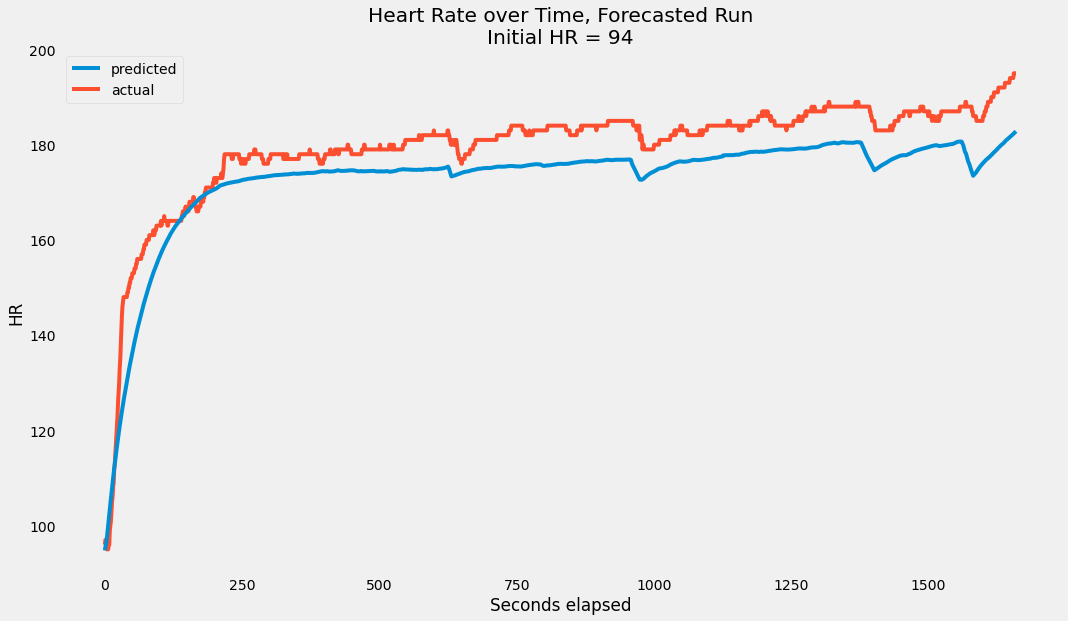

In [29]:
# Initial condition
hr_0 = 94
hr = hr_0

# List of forecasted HRs
hr_list = []
for i in range(len(test)):
    hr = mlp.predict(np.append(test.iloc[i,1:X.shape[1]], hr).reshape(1,-1))
    hr_list.append(hr[0])
    
plt.plot(hr_list, label = 'predicted', zorder = 2)
plt.plot(test['hr'], label = 'actual', zorder = 1)
plt.legend()

plt.title(f'Heart Rate over Time, Forecasted Run\nInitial HR = {hr_0}')
plt.xlabel('Seconds elapsed')
plt.ylabel('HR');

### NN hyperparameter tuning using GridSearchCV

In [ ]:
%%time
# Use itertools to create different number of hidden layers and hidden layer sizes
it = list(itertools.combinations([7, 8, 9, 10], 1))
# it.extend(list(itertools.combinations([7, 8, 9, 10], 2)))
# it.extend(list(itertools.combinations([7, 8, 9, 10], 3)))

# Create and fit GridSearchCV object
parameters = {'hidden_layer_sizes': it, 'activation': ['relu', 'identity', 'logistic', 'tanh']}
mlp_grid = GridSearchCV(MLPRegressor(max_iter = 2000), parameters, scoring = bic_scorer, cv = 10)
mlp_grid.fit(X, data['hr'])

# Pick best model and fit using training subset
best_mlp = mlp_grid.best_estimator_
best_mlp.fit(X, data['hr'])

best_mlp